<a href="https://colab.research.google.com/github/sanjeevrs2000/CS6910-Assignment/blob/main/Assignment_1_wandb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import keras
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import wandb

In [ ]:
from keras.datasets import fashion_mnist

In [ ]:
(trainx, trainy), (testx, testy)= fashion_mnist.load_data()

In [ ]:
classes = np.unique(trainy)
index_mat = [0]*10
for i in classes:
  index_mat[i] = trainy.tolist().index(i)
index_mat

[1, 16, 5, 3, 19, 8, 18, 6, 23, 0]

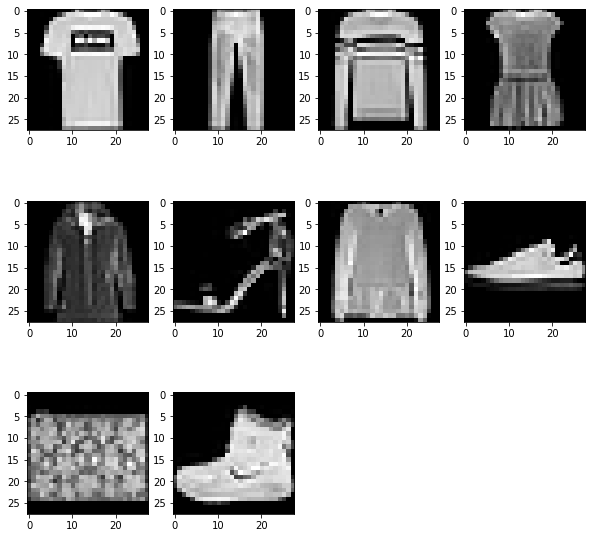

In [ ]:
plt.figure(figsize=(10,10))

for j, i in enumerate(index_mat):
  plt.subplot(3,4,j+1)
  plt.imshow(trainx[i], cmap=plt.get_cmap('gray'))
  
plt.show()

**Defining the Neural Network**


In [ ]:
num_hidden_layers = 3    #Input the number of hidden layers here         

input_layer_size = 784  #input number of inputs here

output_layer_size = 10  #input number of output nodes here

num_nodes = [input_layer_size, 32, 32, 32, output_layer_size]  # input number of nodes in each layer here!

num_weight_mat = num_hidden_layers+1

**Weight Initialization Functions**

In [ ]:
def init_random():
  weights={}
  bias = {}
  for i in  range(1,num_weight_mat+1):
    weights['W%s'% i] = np.random.randn(int(num_nodes[i]),int(num_nodes[i-1]))
    bias['b%s'% i] = np.random.randn(int(num_nodes[i]))
    
  return weights, bias

def init_xavier():
  weights={}
  bias = {}
  for i in  range(1,num_weight_mat+1):
    weights['W%s'%i] = np.random.normal(0, 1/input_layer_size ,size=([int(num_nodes[i]),int(num_nodes[i-1])]))
    bias['b%s'%i] = np.ones(int(num_nodes[i]))
    
  return weights, bias

def init_zeros():
  weights={}
  bias = {}
  for i in  range(1,num_weight_mat+1):
    weights['W%s'% i] = np.zeros([int(num_nodes[i]),int(num_nodes[i-1])])
    bias['b%s'% i] = np.zeros(int(num_nodes[i]))

  return weights,bias


**Activation Functions**

In [ ]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def tanh(x):
  return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def relu(x):
  if x<0:
    return 0
  else:
    return x

**Gradients of Activation functions**

In [ ]:
def grad_tanh(x):
  return 1-(tanh(x))^2

def grad_relu(x):
  if x<0:
    return 0
  else:
    return 1

def grad_sigmoid(x):
  return (sigmoid(x)*(1-sigmoid(x)))

**Output Function**

In [ ]:
def softmax(x):
    # Numerically stable with large exponentials
    exps = np.exp(x )
    return exps / np.sum(exps)

**Funtion for Forward Propagation**

In [ ]:
"""
Inputs required:

  weights and bias
  x_train
  activation function
  output function
  num of hidden layers


"""



def forward_prop(w,b,x, activation):
  Acti = {}
  H = {}
  
  H['H0'] = x
  
  for i in range(1,num_hidden_layers+1):
    Acti[('A%s'% i)] = np.matmul(w['W%s'% i],H[('H%s'% (i-1))])+b['b%s'% i]
    H['H%s'% i] = activation(Acti['A%s'% i])
  
  Acti['A%s'%(num_hidden_layers+1)]= np.matmul(w['W%s'% (num_hidden_layers+1)],H['H%s'% (num_hidden_layers)])+b['b%s'% (num_hidden_layers+1)]
  y_hat = output(Acti['A%s'% (num_hidden_layers+1)])  
  
  return y_hat, Acti, H



In [ ]:
x_train = trainx.reshape(60000,784)/255.0
#one hot encoding y 
temp = np.zeros((60000,10))
temp[np.arange(60000),trainy] = 1
y_train=temp
y_train
#trainy

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Funtion for Back propagation**

In [ ]:
"""

# grad_A[Al] = -(y-y_hat)
# grad_W[Wk] = grad_A[Ak]*H[H(k-1)]'
# grad_b[bk] = grad_A[Ak]
# grad_H[H(k-1)] = W[Wk]'*grad_A[Ak]
# grad_A[A(k-1)] = grad_H[H(k-1)] (dot) grad_g(A(k-1)) 

# y(one-hot-encoded)
#y_hat
#H matrix from feed forward
#A matrix from feed forward
#grad_g func

Inputs required:

  weights and bias
  forward_prop (y_hat, A, H)
  x_train, y_train
  activation func
  Derivative of activation func
  num of hidden layers



"""


def back_prop( w,b,der_activ ,x,y):
  grad_A = {}
  grad_W = {}
  grad_b = {}
  grad_H = {}  

  y_hat, A, H = forward_prop(w,b,x, sigmoid)

  grad_A['A%s'% (num_hidden_layers+1)] = -(y-y_hat)

  for i in range(num_hidden_layers+1, 1, -1):
    
    grad_W['W%s'%i] = np.matmul(grad_A['A%s'%i].reshape(-1,1), H['H%s'%(i-1)].reshape(1,-1))

    grad_b['b%s'%i] = grad_A['A%s'%i]

    grad_H['H%s'%(i-1)] = np.dot(np.transpose(w['W%s'%i]), grad_A['A%s'%i]) #check once if this is logically correct (Looks good)

    grad_A['A%s'%(i-1)] = np.multiply(grad_H['H%s'%(i-1)], der_activ(A['A%s'%(i-1)]))

  grad_W['W1'] = np.multiply(grad_A['A1'].reshape(-1,1), H['H0'].reshape(1,-1))

  grad_b['b1'] = grad_A['A1']

  return grad_W, grad_b





## **Optimization Funtions**



**Stochastic Gradient descent**

In [ ]:
"""
Inputs required:

  X, Y => x_train and y_train
  epochs
  eta
  weights and bias
  grad of activation func
  num of hidden layers



"""


def sgd(epochs, eta):

  for k in range(epochs):
    for x,y in zip(X,Y):
      grad_w,grad_b=back_prop( weights,bias,grad_sigmoid,x,y)
      for j in range(1,num_hidden_layers+2):
        
        weights['W%s'%j]-=(grad_w['W%s'%j])*eta
        bias['b%s'%j]-=(grad_b['b%s'%j])*eta


**Momentum based Gradient descent**


In [ ]:
"""
Inputs required:

  X, Y => x_train and y_train
  epochs
  eta
  weights and bias
  grad of activation func
  num of hidden layers
  batch size
  gamma
  init_zeros()
  


"""

def momentum_gd(epochs,eta,batch_size):

  gamma=0.9
  prev_dw,prev_db=init_zeros()

  for k in range(epochs):
    count=0   
   
    dw,db=init_zeros()
    
    for x,y in zip(X,Y):
      
      if count==0:
        dw,db=init_zeros()
      
      grad_w,grad_b=back_prop( weights,bias, grad_sigmoid,x,y)

      for j in range(1,num_hidden_layers+2):
        dw['W%s'%j]+=(grad_w['W%s'%j])
        db['b%s'%j]+=(grad_b['b%s'%j])



      count+=1

      if count%batch_size==0:
        weights['W%s'%j]=weights['W%s'%j]-(prev_dw['W%s'%j])*gamma-(dw['W%s'%j])*eta
        bias['b%s'%j]=bias['b%s'%j]-(prev_db['b%s'%j])*gamma-(db['b%s'%j])*eta

        prev_dw['W%s'%j]=(prev_dw['W%s'%j])*gamma+(dw['W%s'%j])*eta
        prev_db['b%s'%j]=(prev_db['b%s'%j])*gamma+(db['b%s'%j])*eta

        count=0

**Nesterov Accelerated Gradient Descent**

In [ ]:
def nesterov(epochs,eta,batch_size):

  gamma=0.9
  prev_vw,prev_vb=init_zeros()
  temp_w,temp_b=init_zeros()
  dw,db=init_zeros()
  v_w,v_b=init_zeros()

  for k in range(epochs):
    count=0

    if count==0:
      for j in range(1,num_hidden_layers+2):
          v_w['W%s'%j]=prev_vw['W%s'%j]*gamma 
          v_b['b%s'%j]=prev_vb['b%s'%j]*gamma 


    for x,y in zip(X,Y):
      if count==0:
        dw,db=init_zeros()

      for j in range(1,num_hidden_layers+2):
        temp_w['W%s'%j]=weights['W%s'%j]-v_w['W%s'%j]
        temp_b['b%s'%j]=bias['b%s'%j]-v_b['b%s'%j]
      
      grad_w,grad_b=back_prop(temp_w,temp_b,grad_sigmoid,x,y)      
      for j in range(1,num_hidden_layers+2):
        dw['W%s'%j]+=(grad_w['W%s'%j])
        db['b%s'%j]+=(grad_b['b%s'%j])
      count+=1

      if count%batch_size==0:
        
        for j in range(1,num_hidden_layers+2):
          v_w['W%s'%j]=(prev_vw['W%s'%j])*gamma + (dw['W%s'%j])*eta
          v_b['b%s'%j]=(prev_vb['b%s'%j])*gamma + (db['b%s'%j])*eta
          weights['W%s'%j]-=v_w['W%s'%j]
          bias['b%s'%j]-=v_b['b%s'%j]
          prev_vw['W%s'%j]=v_w['W%s'%j]
          prev_vb['b%s'%j]=v_b['b%s'%j]

        count=0

**Adagrad**


In [ ]:
def adagrad(epochs,eta,batch_size):
  
  eps = 1e-8

  v_w,v_b=init_zeros()

  for k in range(epochs):
    count=0
    dw,db=init_zeros()
    
    for x,y in zip(X,Y):

      if count==0:
        dw,db=init_zeros()
      
      grad_w,grad_b=back_prop( weights,bias, grad_sigmoid,x,y)
      for j in range(1,num_hidden_layers+2):
        dw['W%s'%j]+=(grad_w['W%s'%j])
        db['b%s'%j]+=(grad_b['b%s'%j])
      count+=1

      if count%batch_size==0:

        for j in range(1,num_hidden_layers+2):
          v_w['W%s'%j] += np.square(dw['W%s'%j])
          v_b['b%s'%j] += np.square(db['b%s'%j]) 
          weights['W%s'%j] -= (dw['W%s'%j])*(eta/np.sqrt(v_w['W%s'%j] + eps))
          bias['b%s'%j] -= (db['b%s'%j])*(eta/np.sqrt(v_b['b%s'%j] + eps))

          count=0

**RMSProp**

In [ ]:
def rmsprop(epochs,eta,batch_size):
  
  eps = 1e-8
  beta1 = 0.9

  v_w,v_b=init_zeros()

  for k in range(epochs):
    count=0
    dw,db=init_zeros()
    
    for x,y in zip(X,Y):

      if count==0:
        dw,db=init_zeros()
      
      grad_w,grad_b=back_prop( weights,bias, grad_sigmoid,x,y)
      for j in range(1,num_hidden_layers+2):
        dw['W%s'%j]+=(grad_w['W%s'%j])
        db['b%s'%j]+=(grad_b['b%s'%j])
      count+=1

      if count%batch_size==0:

        for j in range(1,num_hidden_layers+2):
          v_w['W%s'%j] = beta1*v_w['W%s'%j] + (1-beta1)*np.square(dw['W%s'%j])
          v_b['b%s'%j] = beta1*v_b['b%s'%j] + (1-beta1)*np.square(db['b%s'%j]) 
          weights['W%s'%j] -= (dw['W%s'%j])*(eta/np.sqrt(v_w['W%s'%j] + eps))
          bias['b%s'%j] -= (db['b%s'%j])*(eta/np.sqrt(v_b['b%s'%j] + eps))

          count=0

**Adam**

In [ ]:
def adam(epochs,eta,batch_size):
  
  eps = 1e-8
  beta1 = 0.9
  beta2 = 0.999

  v_w,v_b=init_zeros()
  v_w_hat,v_b_hat=init_zeros()

  m_w,m_b=init_zeros()
  m_w_hat,m_b_hat=init_zeros()

  for k in range(epochs):
    
    count=0
    dw,db=init_zeros()
    
    for x,y in zip(X,Y):

      if count==0:
        dw,db=init_zeros()
      
      grad_w,grad_b=back_prop( weights,bias, grad_sigmoid,x,y)
      for j in range(1,num_hidden_layers+2):
        dw['W%s'%j]+=(grad_w['W%s'%j])
        db['b%s'%j]+=(grad_b['b%s'%j])
      count+=1

      if count%batch_size==0:

        for j in range(1,num_hidden_layers+2):
          
          v_w['W%s'%j] = beta2*v_w['W%s'%j] + (1-beta2)*np.square(dw['W%s'%j])
          v_b['b%s'%j] = beta2*v_b['b%s'%j] + (1-beta2)*np.square(db['b%s'%j]) 

          v_w_hat['W%s'%j] = v_w['W%s'%j]*1/(1-math.pow(beta2,k+1))
          v_b_hat['b%s'%j] = v_b['b%s'%j]*1/(1-math.pow(beta2,k+1))

          m_w['W%s'%j] = beta1*m_w['W%s'%j] + (1-beta1)*(dw['W%s'%j])
          m_b['b%s'%j] = beta1*m_b['b%s'%j] + (1-beta1)*(db['b%s'%j]) 

          m_w_hat['W%s'%j] = m_w['W%s'%j]*1/(1-math.pow(beta1,k+1))
          m_b_hat['b%s'%j] = m_b['b%s'%j]*1/(1-math.pow(beta1,k+1))
          
          weights['W%s'%j] -= (m_w_hat['W%s'%j])*(eta/np.sqrt(v_w_hat['W%s'%j] + eps)) 
          bias['b%s'%j] -= (m_b_hat['b%s'%j])*(eta/np.sqrt(v_b_hat['b%s'%j] + eps))

          count=0

In [ ]:
#sample run
X,Y=x_train[:1000],y_train[:1000]
weights,bias=init_random()
#momentum_gd(5,0.1,64) # takes approx 2 mins to train full training set ie 60000 inputs
#sgd(0.1,5) 
nesterov(5,0.1,32)

#forward_prop()

NameError: name 'output' is not defined

# **Train Function**

In [ ]:
"""
Code for train funtion:

Inputs:

  1. num_epochs
  2. num_hidden_layers
  3. size of hidden layers
  4. weight decay (L2 regularisation)
  5. learning rate
  6. Optimizer
  7. Batch size
  8. weight initialisation
  9. activation functions

  10. x_train, y_train
  11. train-test-split

def train(inputs):

  # X,Y,X_val,Y_val = split data into train and validation data sets
  
  # Y should be one-hot encoded!!!!

  # if loops for optimiser
  # if loop for activation func
  # if loop for derivative of activation func
  # if loop for weight initialization

  #initialize weights
  #call optimizer


"""
X=x_train[:50000]
Y=y_train[:50000]
x_val=x_train[50000:]
y_val=y_train[50000:]
epochs=5
eta=0.01 
nhidden=3
size=32
initialization='xavier'
activation='sigmoid'
optimization='sgd'
batch_size=16
gamma=0.9 
wt_decay=0 
output=softmax

In [ ]:
def error(y, y_hat):
  return -np.log(np.dot(y, y_hat))

def val_error():
  y_pred=np.zeros(10000)
  val_loss=0
  for x,y in zip(x_val,y_val):
    fx=forward_prop(weights,bias,x,sigmoid)[0]
    val_loss+=error(y,fx)

  return val_loss

#print(val_error())

In [ ]:
sweep_config = {
    'method': 'random', #grid, random, bayes
    'metric': {
      'name': 'loss',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'eta': {
            'values': [1e-2, 1e-3, 1e-4]
        },
        'optimization': {
            'values': ['adam']
        },
        'activation': {
            'values': ['sigmoid']
        }
    }
}

In [ ]:
def Train():            #define inputs
  
  config_defaults = {
        'epochs': 5,
        'batch_size':64,
        'eta': 1e-2,
        'activation': 'sigmoid',
        'optimization': 'adam',
        }

  wandb.init(config=config_defaults)

  config = wandb.config
  
  num_hidden_layers = nhidden            

  input_layer_size = 784  #input number of inputs here

  output_layer_size = 10  #input number of output nodes here

  num_nodes = [input_layer_size]

  #num_nodes = num_nodes.append(input_layer_size)
  for i in range(nhidden):
    num_nodes.append(size)
  num_nodes.append(output_layer_size)

  num_weight_mat = num_hidden_layers+1


  L2 = wt_decay

  #Setting weight initialization function
  if initialization == 'random':
    weights,bias=init_random()
  elif initialization == 'xavier':
    weights,bias = init_xavier()
  else:
    print('weight initialization given is not available')

  #Setting activation function and its derivative
  if activation == 'sigmoid':
    activ = sigmoid
    der_activ = grad_sigmoid
  elif activation == 'tanh':
    activ = tanh
    der_activ = grad_tanh
  elif activation == 'relu':
    activ = relu
    der_activ = grad_relu

  #Setting optimization function
  if optimization == 'sgd':
    sgd(epochs, eta)
  elif optimization == 'momentum':
    momentum_gd(epochs, eta, batch_size)
  elif optimization == 'nesterov':
    nesterov(epochs,eta,batch_size)
  elif optimization == 'rmsprop':
    rmsprop(epochs,eta,batch_size)
  elif optimization =='adam':
    adam(epocha,eta,batch_size)
  else:
    print('Optimization algo given is not available')

  if optimization == 'sgd':
    sgd(epochs=epochs, eta=eta)
  elif optimization == 'momentum':
    momentum_gd(epochs=epochs, eta=eta, batch_size=batch_size)
  elif optimization == 'nesterov':
    nesterov(epochs=epochs,eta=eta,batch_size=batch_size)
  else:
    print('Optimization algo given is not available')

  val_loss=val_error()
  params={'epochs':epochs,'learning rate':eta,'validation loss':val_loss}
  wandb.log(params)

In [ ]:
#Train()

In [ ]:
sweep_id = wandb.sweep(sweep_config,entity='sanjeevrs',project='assignment1')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 1h3ij5e9
Sweep URL: https://wandb.ai/sanjeevrs/assignment1/sweeps/1h3ij5e9


In [ ]:
wandb.agent(sweep_id, Train)